**Table of Contents** <br>

* [1) Importing Libraries](#importlibraries)
* [2) Loading Data](#loadingdata)
* [3) Baseline Preprocessing](#preprocessing)
* [4) Data Understanding](#understanding)
* [5) Modelling](#modelling)

<a class="anchor" id="importlibraries">

# 1. Importing Libraries

</a>

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression


from wordcloud import WordCloud

In [2]:
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('stopwords')

<a class="anchor" id="loadingdata">

# 2. Loading Data

</a>

In [3]:
input_file1 = 'thesis dataset_original.xlsx'
df = pd.read_excel(input_file1)

In [4]:
input_file2 = 'thesis dataset_dev.xlsx'
dev = pd.read_excel(input_file2)

<a class="anchor" id="preprocessing">

# 3. Preprocessing

</a>

In [5]:
stop = text.ENGLISH_STOP_WORDS
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [6]:
def lemmatize_sentences(sentence):
    tokens = sentence.split()
    lemmd_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmd_tokens)

def text_preprocessing(df_, col):
    
    df = df_.copy()
    df['original'] = df[col]
    """
    Baseline preprocessing: 
        - lowercase
        - remove symbols (keep letters, ?, !)
        - remove stop words in pipeline instead of in preprocessing
        - use lemmatizing instead of stemming
    """
    keep = ['?', '!']
    
    ## Lowercase
    df[col] = df[col].str.lower()
    
    ## Remove symbols
    df[col] = df[col].apply(lambda x: ''.join([re.sub(r'[\.;:,\"\'\/]','',x)]))
        
    ## Use Lemmatizer
    df[col] = df[col].apply(lambda x: lemmatize_sentences(x) )
    
    ## Remove excess spaces
    df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x))
    df[col] = df[col].str.strip()
    
    return df

In [7]:
df_prep = text_preprocessing(df, 'Comment Summary')

In [8]:
df_prep

,Company Name,Satisfaction Index (%),Company Category,Name,Date,Resolution Status,Rating (out of 10),Comment Summary,original
0,Temu Portugal,72.2,International Marketplaces,Carla Ferreira,2024-10-24,Resolved,5,tired of complaining to temu they don’t return...,Tired of complaining to Temu; they don’t retur...
1,Temu Portugal,72.2,International Marketplaces,Helou,2024-11-20,Resolved,5,damaged product unable to upload video and tem...,"Damaged products, unable to upload videos, and..."
2,Temu Portugal,72.2,International Marketplaces,Joaquim Antunes,2024-11-18,Resolved,7,order not delivered inadequate support from temu,"Order not delivered, inadequate support from T..."
3,Temu Portugal,72.2,International Marketplaces,Ana Lopo,2024-06-11,Unresolved,1,order marked a delivered but never received at...,Order marked as delivered but never received. ...
4,Temu Portugal,72.2,International Marketplaces,André Cuqui,2024-02-11,Resolved,9,order delayed received €5 cashback a compensat...,"Order delayed, received €5 cashback as compens..."
...,...,...,...,...,...,...,...,...,...
2309,Worten,87.1,Technology & Home Appliances,Ricardo,2024-11-14,Resolved,10,refused repair request without offering budget...,Refused repair request without offering budget...
2310,Worten,87.1,Technology & Home Appliances,Elsa Moreira,2024-11-14,Resolved,7,poor service for fridge return and re-collecti...,Poor service for fridge return and re-collecti...
2311,Worten,87.1,Technology & Home Appliances,Sandrine Ferreira,2024-11-14,Resolved,10,disappointment with damaged aesthetic of produ...,Disappointment with damaged aesthetic of produ...
2312,Worten,87.1,Technology & Home Appliances,Amadeu Jose Pereira dos Anjos,2024-11-13,Resolved,9,rusted basket issue in becken dishwasher,Rusted basket issue in Becken dishwasher.


In [9]:
dev_prep = text_preprocessing(dev, 'Comment Summary')

In [10]:
dev_prep

,Company Name,Satisfaction Index (%),Company Category,Name,Date,Resolution Status,Rating (out of 10),Comment Summary,Deceptive Pattern,Type,original
0,Temu Portugal,72.2,International Marketplaces,Helou,2024-11-19,Resolved,1,damaged order returning them would cause addit...,No,NaN,Damaged orders; returning them would cause add...
1,Temu Portugal,72.2,International Marketplaces,Gonçalo Pereira,2024-11-16,Unresolved,1,received the wrong item in the package temu re...,Yes,Bait and switch,Received the wrong items in the package. Temu ...
2,Temu Portugal,72.2,International Marketplaces,Bruna,2024-04-11,Resolved,7,frequently receives damaged item despite regul...,No,NaN,Frequently receives damaged items despite regu...
3,Temu Portugal,72.2,International Marketplaces,Nuno Cardoso,2024-01-11,Resolved,6,ordered 99 unit of a product but received only...,Yes,Bait and switch,Ordered 99 units of a product but received onl...
4,Temu Portugal,72.2,International Marketplaces,Lara,2024-10-18,Resolved,9,order stuck in custom for a prolonged period e...,No,NaN,"Order stuck in customs for a prolonged period,..."
...,...,...,...,...,...,...,...,...,...,...,...
546,Instagram,16.0,"Social Media, Forums & Blogs",Frederica Campos,2024-07-10,Unresolved,1,ordered 2 outfit from boutiquebellasfashion pa...,No,NaN,"Ordered 2 outfits from Boutique.bellasfashion,..."
547,Temu Portugal,72.2,International Marketplaces,Paulo Coutinho Feio,2024-04-11,Resolved,4,claim to have been scammed by temu payment mad...,No,NaN,"Claims to have been scammed by Temu, payment m..."
548,MB WAY,92.1,Digital Banks and Finance Apps,Rui Costa,2024-06-19,Resolved,2,requested €10 from mb way challenge but faced ...,Yes,Sneaking,Requested €10 from MB WAY Challenge but faced ...
549,Worten,87.1,Technology & Home Appliances,Jane Karla Rodrigues Gogel,2024-11-14,Resolved,1,failed to meet delivery promise of 1 business day,Yes,Bait and switch,Failed to meet delivery promise of 1 business ...


<a class="anchor" id="understanding">

# 4. Data Understanding

</a>

In [11]:
category_colors = {
    "International Marketplaces": "#5FB49C",   # Soft Teal
    "Accommodation, Travel and Tourism": "#7AC7A5",  # Bolder Mint
    "Social Media, Forums & Blogs": "#56C6C6",  # Punchy Aqua
    "Digital Banks and Finance Apps": "#11698E",  # Deep Blue
    "Technology & Home Appliances": "#4F6D7A"   # Slate Blue
}

## Companies, per category

In [12]:
full_df = pd.concat([df_prep, dev_prep], ignore_index=True)

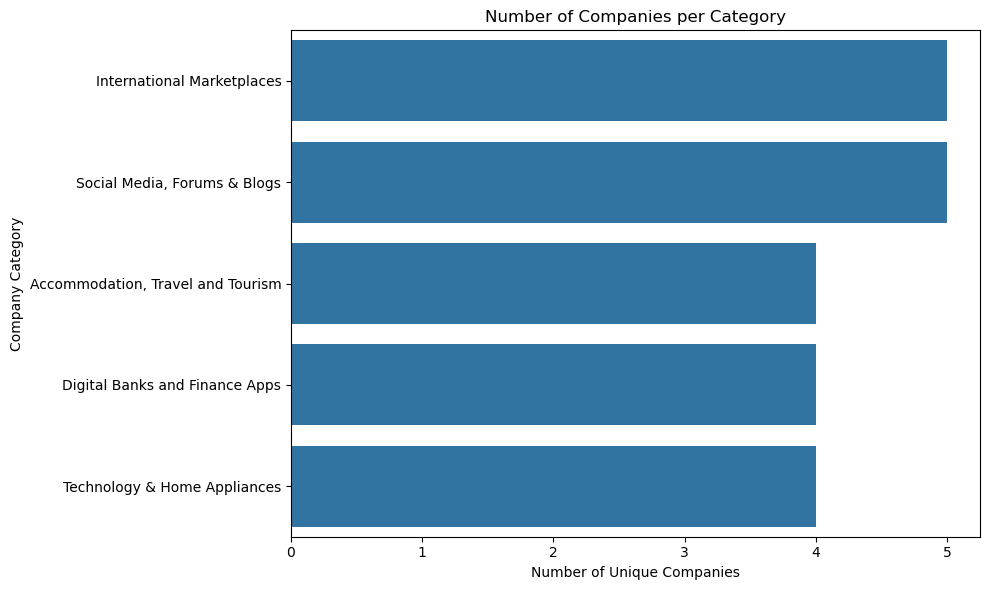

In [13]:
# Sort your data (optional, for prettier plots)
company_counts = full_df.groupby("Company Category")["Company Name"].nunique().reset_index()
company_counts = company_counts.rename(columns={"Company Name": "number of companies"})
company_counts = company_counts.sort_values("number of companies", ascending=False)

# Apply the custom color palette based on the category
colors = company_counts["Company Category"].map(category_colors)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=company_counts,
    y="Company Category",
    x="number of companies",
)
plt.title("Number of Companies per Category")
plt.xlabel("Number of Unique Companies")
plt.ylabel("Company Category")
plt.tight_layout()
plt.show()



## Date range of complaints, per category

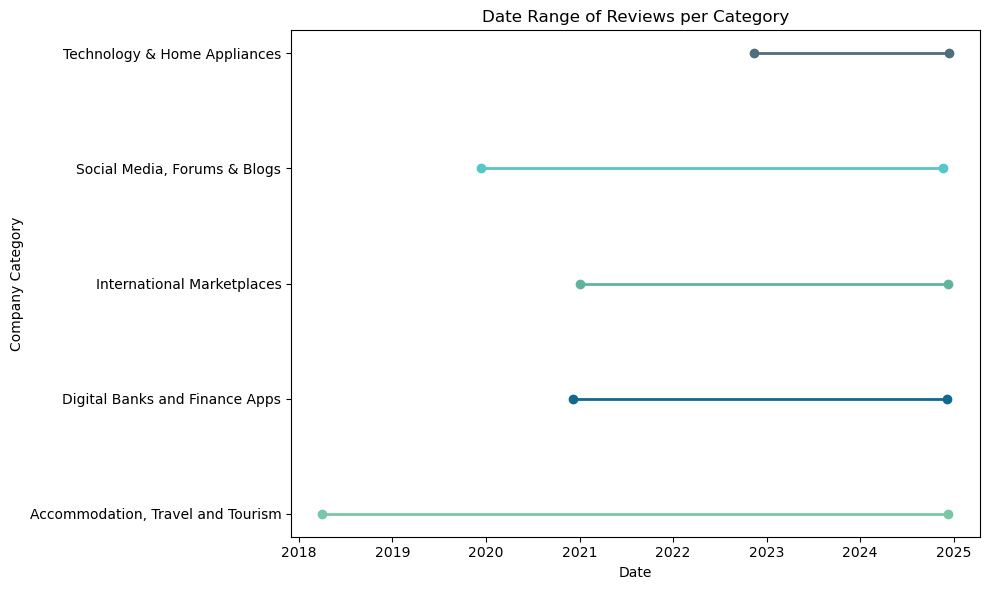

In [14]:
date_ranges = full_df.groupby("Company Category")["Date"].agg(["min", "max"]).reset_index()

# Plotting
plt.figure(figsize=(10, 6))

for i, row in date_ranges.iterrows():
    category = row["Company Category"]
    color = category_colors.get(category, "#333333")  # fallback in case category isn't mapped
    plt.plot([row['min'], row['max']], [i, i], marker='o', linewidth=2, color=color)

plt.yticks(range(len(date_ranges)), date_ranges["Company Category"])
plt.title("Date Range of Reviews per Category")
plt.xlabel("Date")
plt.ylabel("Company Category")
plt.grid(False)
plt.tight_layout()
plt.show()

## Top reviews per company, per category

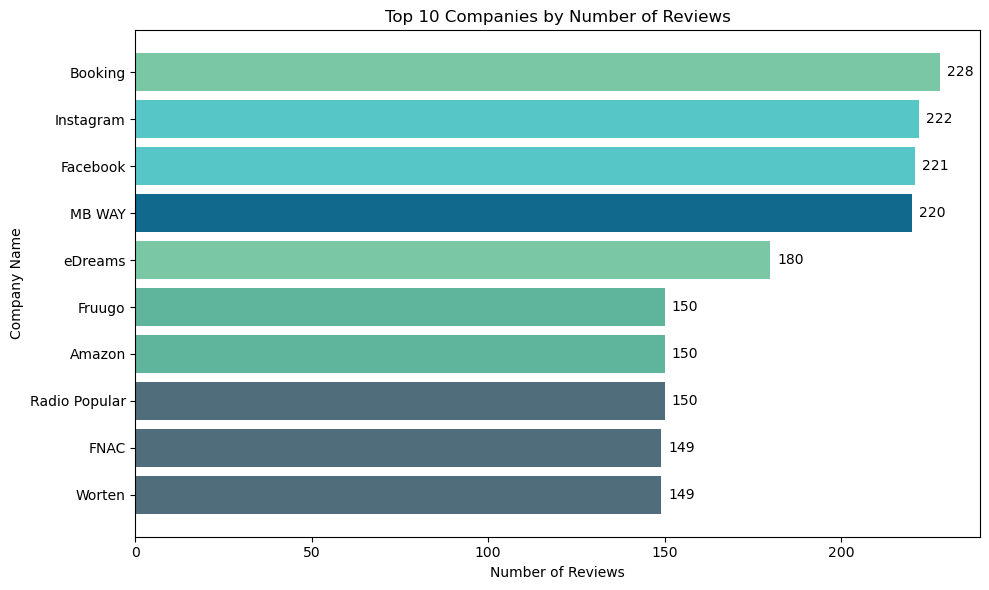

In [15]:
# Step 1: Top 10 companies
top_reviews = (
    full_df.groupby(["Company Category", "Company Name"])
    .size()
    .reset_index(name="review count")
    .sort_values(by="review count", ascending=False)
)

top10 = top_reviews.head(10).sort_values("review count", ascending=True)

# Step 2: Map color per row based on category
top10["color"] = top10["Company Category"].map(category_colors)

# Step 3: Plot WITHOUT hue
plt.figure(figsize=(10, 6))
bars = plt.barh(
    y=top10["Company Name"],
    width=top10["review count"],
    color=top10["color"]
)

# Optional: add text labels
for i, (count, name) in enumerate(zip(top10["review count"], top10["Company Name"])):
    plt.text(count + 2, i, str(count), va="center")

# Labels and layout
plt.title("Top 10 Companies by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Company Name")
plt.tight_layout()
plt.show()


## Distribution of Rating, per category

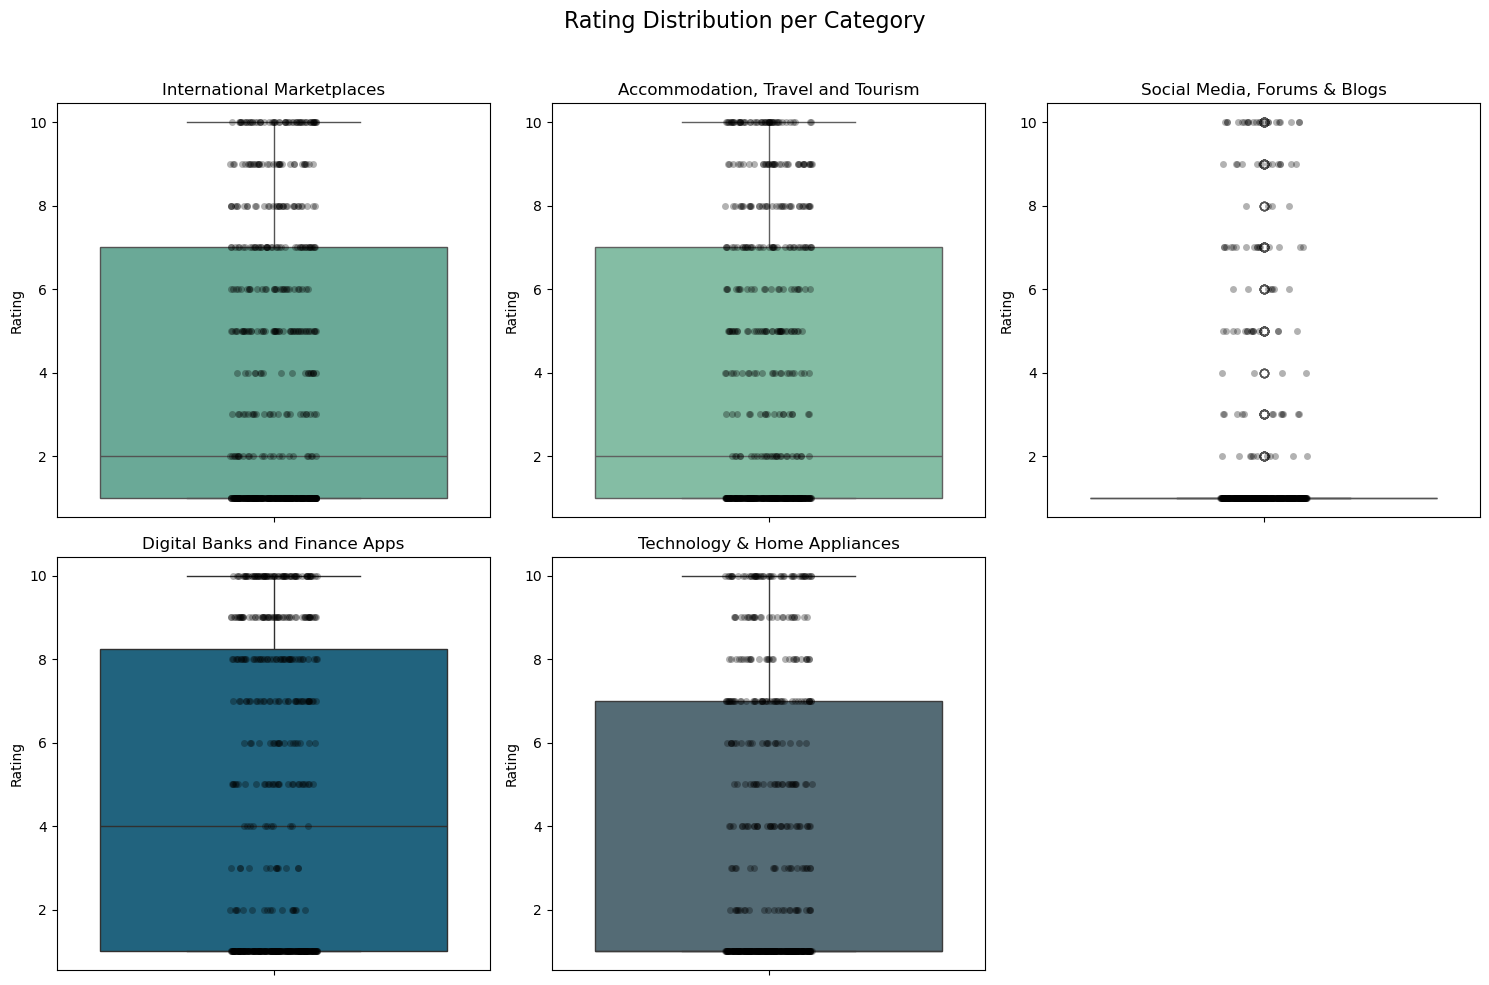

In [16]:
categories = full_df["Company Category"].unique()
num_categories = len(categories)

cols = 3
rows = -(-num_categories // cols) 
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), squeeze=False)

for idx, category in enumerate(categories):
    row, col = divmod(idx, cols)
    ax = axes[row][col]

    category_data = full_df[full_df["Company Category"] == category]
    color = category_colors.get(category, "#999999")  # fallback in case of mismatch

    # Apply single-color boxplot and matching stripplot
    sns.boxplot(
        data=category_data,
        y="Rating (out of 10)",
        ax=ax,
        color=color
    )
    sns.stripplot(
        data=category_data,
        y="Rating (out of 10)",
        color='black',
        alpha=0.3,
        jitter=True,
        ax=ax
    )

    ax.set_title(category)
    ax.set_xlabel("")  # Clean up x-axis
    ax.set_ylabel("Rating")

# Clean up unused subplots if any
for j in range(idx + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols])

plt.suptitle("Rating Distribution per Category", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



## Resolved complaints, per category

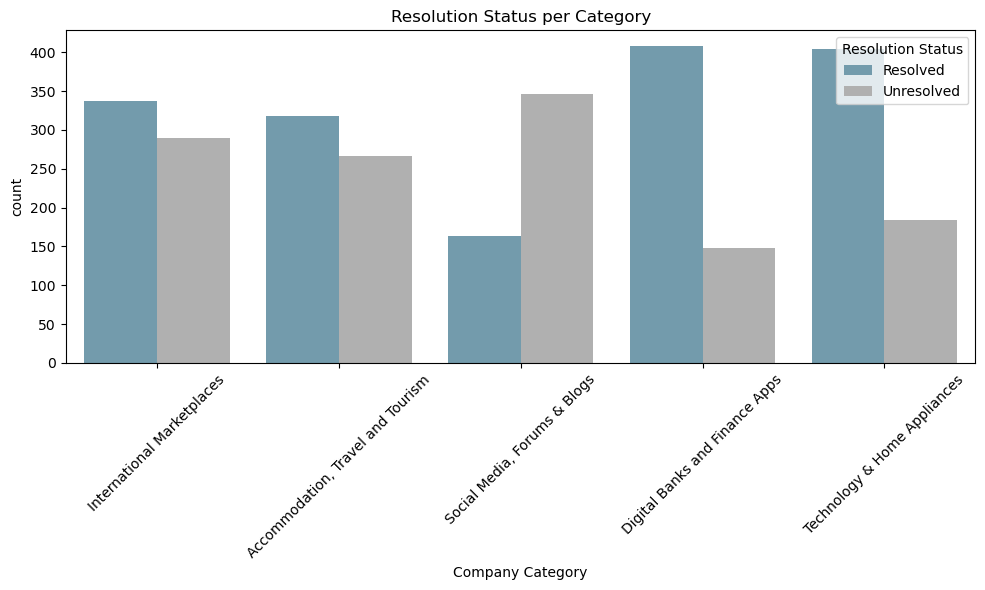

In [17]:
# Define custom neutral palette for binary resolution status
neutral_palette = {
    "Resolved": "#6a9fb5",     # muted slate blue
    "Unresolved": "#B0B0B0"    # soft amber/orange
}

plt.figure(figsize=(10, 6))
sns.countplot(
    data=full_df,
    x="Company Category",
    hue="Resolution Status",
    palette=neutral_palette
)
plt.title("Resolution Status per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Keyword Exploration

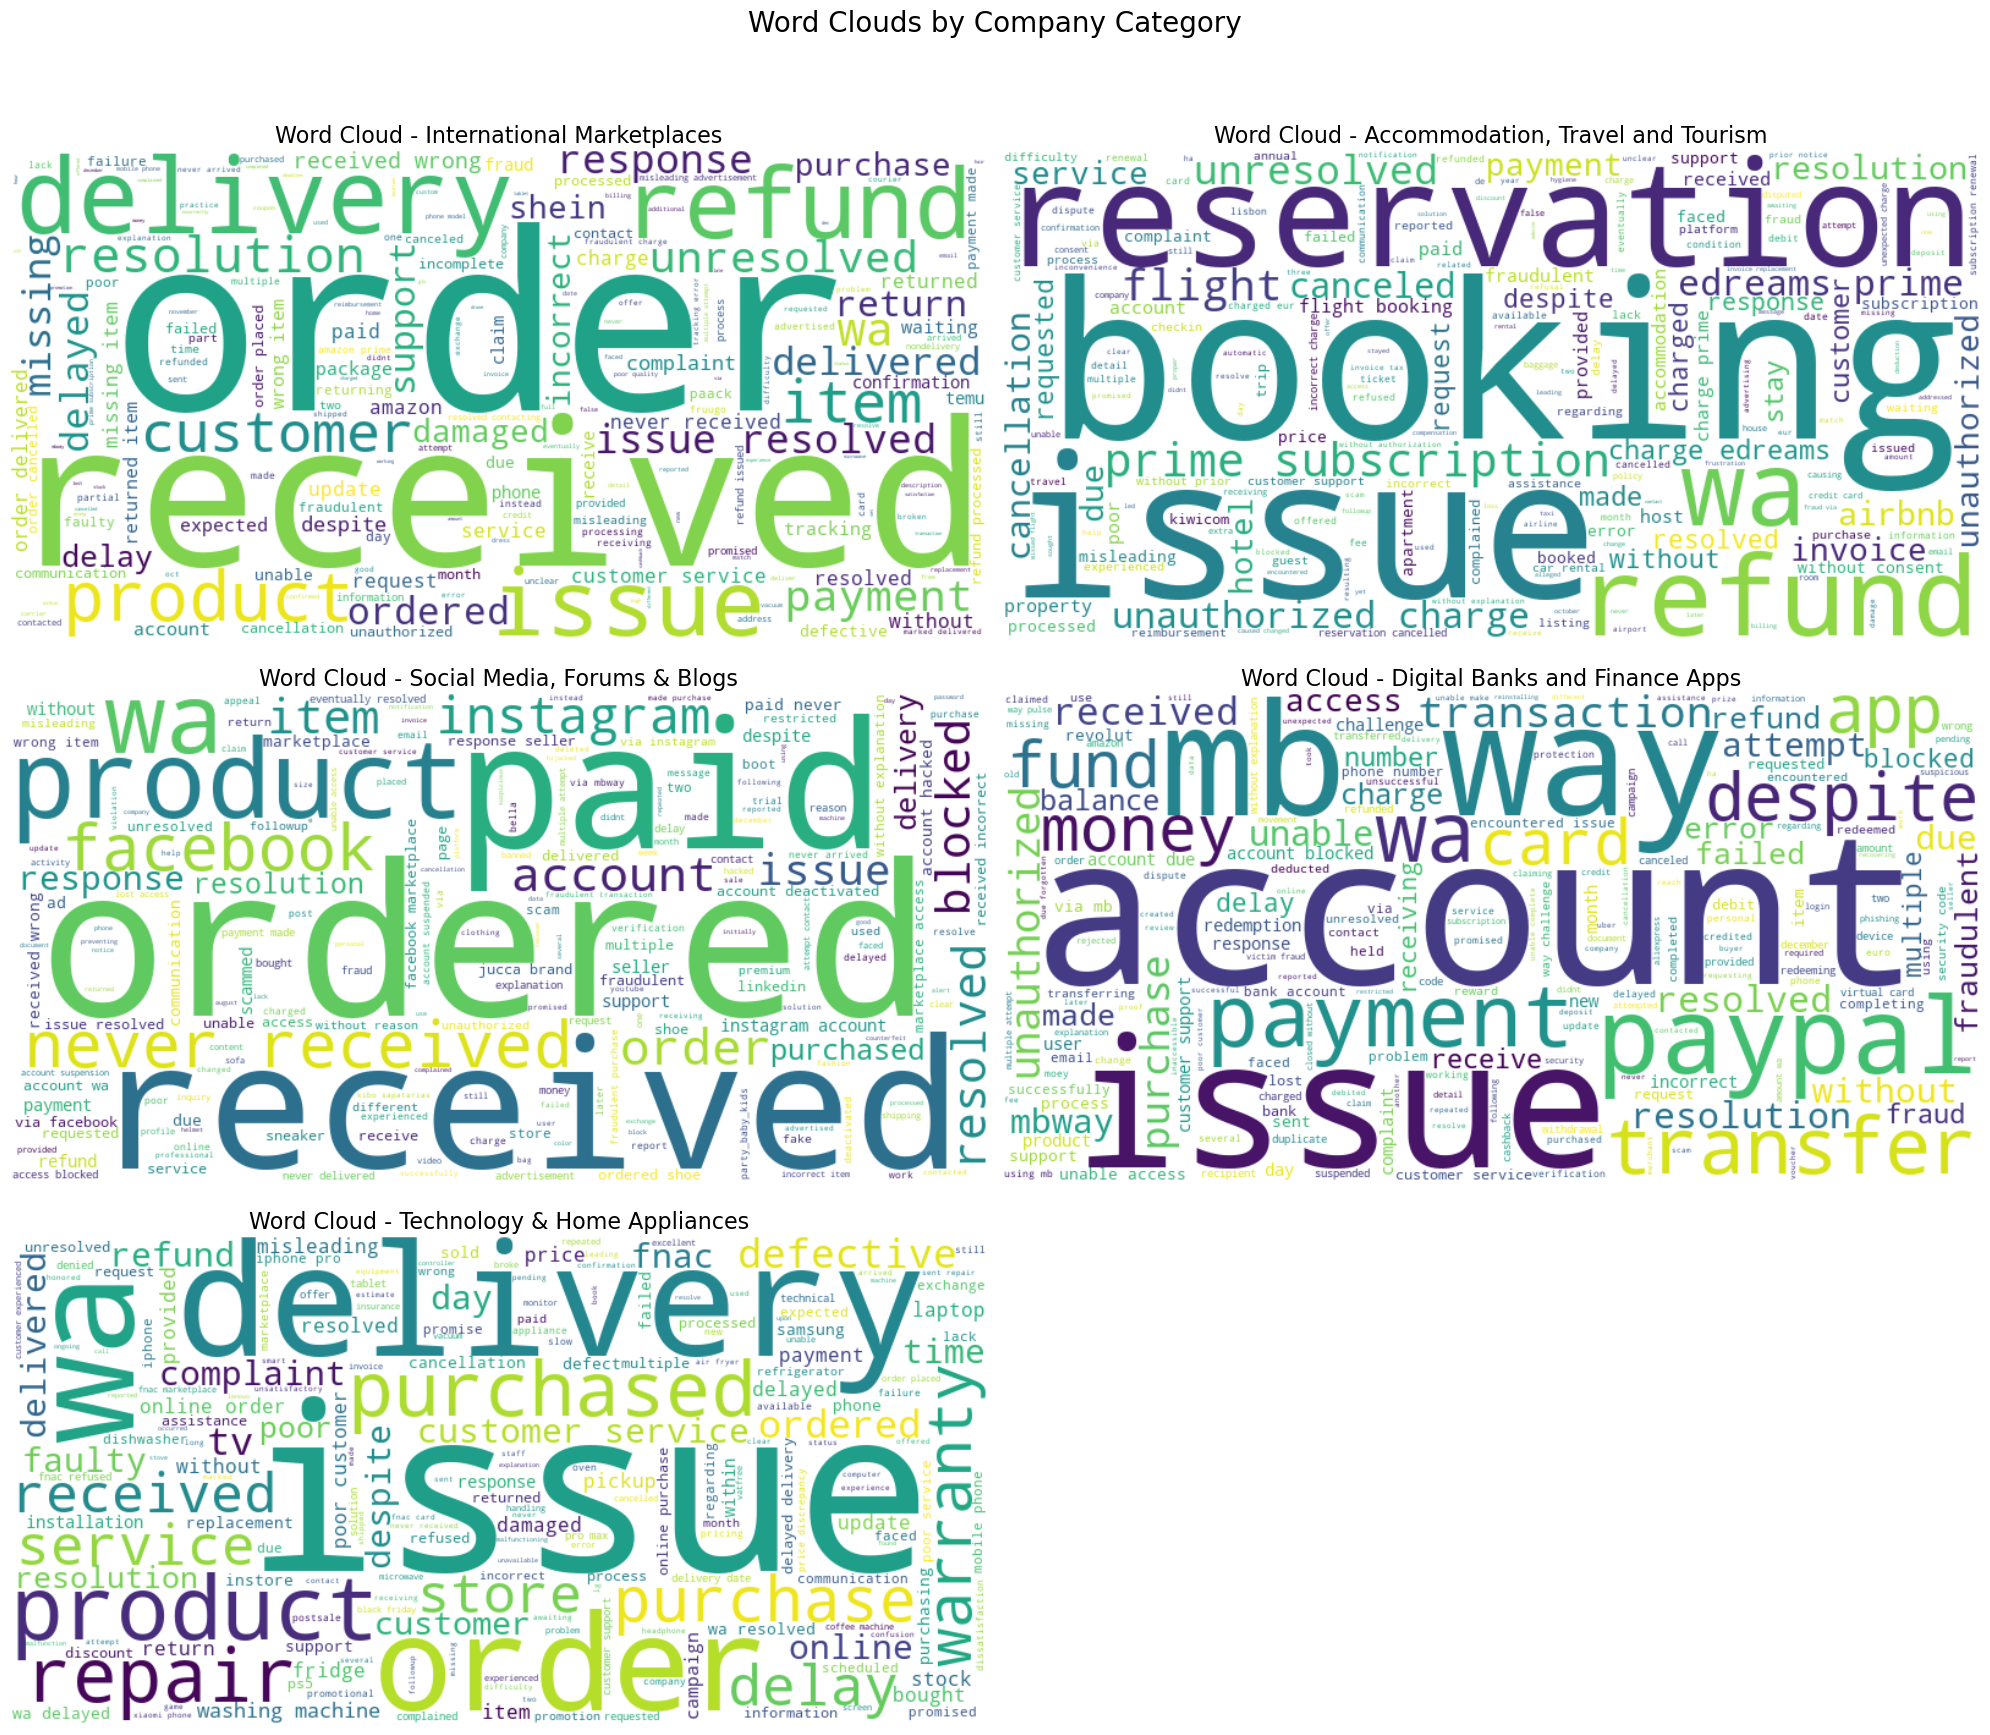

In [18]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

full_df['clean_comment'] = full_df['Comment Summary'].apply(clean_text)

categories = [
    "International Marketplaces",
    "Accommodation, Travel and Tourism",
    "Social Media, Forums & Blogs",
    "Digital Banks and Finance Apps",
    "Technology & Home Appliances"
]

cols = 2
rows = -(-len(categories) // cols)  # Ceiling division
fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 6 * rows))
axes = axes.flatten()

for idx, category in enumerate(categories):
    subset = full_df[full_df['Company Category'] == category]
    text = " ".join(subset['clean_comment'].dropna())

    ax = axes[idx]
    ax.axis("off")
    ax.set_title(f"Word Cloud - {category}", fontsize=16)

    if text.strip() == "":
        ax.text(0.5, 0.5, "Not enough data", fontsize=14, ha='center', va='center')
        continue

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')


for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Word Clouds by Company Category", fontsize=20)
plt.subplots_adjust(top=0.92)  # Room for suptitle
plt.show()

<a class="anchor" id="modelling">

# 5. Modelling

</a>

In [19]:
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

In [20]:
dev_prep['label'] = dev_prep['Deceptive Pattern'].map({'Yes': 1, 'No': 0})

# Split
train_df, test_df = train_test_split(dev_prep, test_size=0.2, stratify=dev_prep['label'], random_state=RANDOM_STATE)


In [21]:
X_train = train_df['Comment Summary']
y_train = train_df['label']

X_test = test_df['Comment Summary']
y_test = test_df['label']

## Metrics

In [22]:
labels = ["Not Deceptive", "Deceptive"]
numlabels = [0, 1]

f1labels = ["F1 " + label for label in labels]
rclabels = ["Recall " + label for label in labels]
pclabels = ["Precision " + label for label in labels]

#
def get_scores(preds, label, cv_score, truth):
    return pd.DataFrame([[label,
               accuracy_score(truth, preds),
               recall_score(truth, preds, average='macro'),
               precision_score(truth, preds, average='macro'),
               f1_score(truth, preds, average='macro'),
               cv_score,
               *(f1_score(truth, preds, average=None, labels=numlabels)),
               *(recall_score(truth, preds, average=None, labels=numlabels)),
               *(precision_score(truth, preds, average=None, labels=numlabels)),
            ]],
             columns=["Model", "Accuracy", "Recall", "Precision", "F1", "Train Accuracy", *f1labels, *rclabels, *pclabels ],
             index=[label]
        )

#
def print_scores(preds, gs_, Y):
    print("Best parameters: ")
    print(gs_.best_params_)
    print("------------------------")

    print("Accuracy:         ", round(accuracy_score(Y, preds), 4))
    print("Macro F1:         ", round(f1_score(Y, preds, average='macro'), 4))
    print("Macro Recall:     ", round(recall_score(Y, preds, average='macro'), 4))
    print("Macro Precision:  ", round(precision_score(Y, preds, average='macro'), 4))
    print("Best Train Score: ", round(gs_.best_score_, 4))
    return


#
def plot_cm(preds, title, Y, filename):
    cm_ = confusion_matrix(Y, preds)
    df_cm = pd.DataFrame(cm_, index=numlabels, columns=numlabels)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    plt.title("Confusion Matrix: " + title, fontsize=12)
    plt.savefig(filename, dpi=300, bbox_inches='tight') 
    plt.show()
    return


In [23]:
score_func = 'accuracy'

<a class="anchor" id="lr_1">

## 5.1. Logistic Regression with TF-IDF

</a>

In [24]:
all_scores = []

In [25]:
pipe_lr_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=5000, random_state=RANDOM_STATE)),
])

grid_lr_tfidf = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__stop_words": [None, 'english'],
    "tfidf__min_df": [1, 5],
    "tfidf__max_df": [0.75, 1.0],
    "tfidf__use_idf": [True, False],
    "classifier__C": [0.01, 0.1, 1, 10],  # Regularization strength
}
gs_lr_tfidf = GridSearchCV(pipe_lr_tfidf, grid_lr_tfidf, n_jobs=-1, cv=10, scoring=score_func, verbose=1
)

gs_lr_tfidf.fit(X_train, y_train)
gs_lr_pred_tfidf = gs_lr_tfidf.predict(X_test)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


In [26]:
print_scores(gs_lr_pred_tfidf, gs_lr_tfidf, Y=y_test)
all_scores.append(get_scores(gs_lr_pred_tfidf, "Logistic Regression TF_IDF", gs_lr_tfidf.best_score_, truth=y_test))

Best parameters: 
{'classifier__C': 10, 'tfidf__max_df': 0.75, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english', 'tfidf__use_idf': True}
------------------------
Accuracy:          0.8919
Macro F1:          0.8767
Macro Recall:      0.8609
Macro Precision:   0.9055
Best Train Score:  0.85


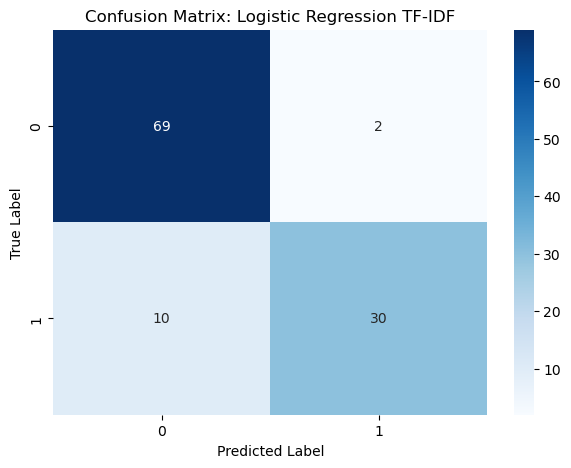

In [27]:
plot_cm(gs_lr_pred_tfidf, "Logistic Regression TF-IDF", Y=y_test, filename='cm_tfidf.png')

<a class="anchor" id="lr_2">

## 5.2. Logistic Regression with CountVectorizer

</a>

In [28]:
#pipe_lr_bow = Pipeline([
#    ('bow', CountVectorizer()),  # Bag of Words
#    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_STATE)),
#])

#grid_lr_bow = {
#    "bow__ngram_range": [(1, 1), (1, 2)],
#    "bow__stop_words": [None, 'english'],
#    "bow__min_df": [1, 5],
#    "bow__max_df": [0.75, 1.0],
#    "classifier__C": [0.01, 0.1, 1, 10],
#}

#gs_lr_bow = GridSearchCV(pipe_lr_bow, grid_lr_bow, cv=10, scoring='f1_macro', n_jobs=-1)

#gs_lr_bow.fit(X_train, y_train)
#gs_lr_pred_bow = gs_lr_bow.predict(X_test)

In [29]:
#print_scores(gs_lr_pred_bow, gs_lr_bow, Y=y_test)
#all_scores.append(get_scores(gs_lr_pred_bow, "Logistic Regression CountVectorizer", gs_lr_bow.best_score_, truth=y_test))

In [30]:
#plot_cm(gs_lr_pred_bow, "Logistic Regression CountVectorizer", Y=y_test, filename='cm_cv.png')

<a class="anchor" id="results">

# 6. Results

</a>

In [37]:
#results_df = pd.DataFrame({
#    "text": X_test.values,
#    "true_label": y_test.values,
#    "predicted": gs_lr_pred_tfidf
#})

# Filter categories
#false_negatives = results_df[(results_df["true_label"] == 1) & (results_df["predicted"] == 0)]
#false_positives = results_df[(results_df["true_label"] == 0) & (results_df["predicted"] == 1)]
#true_positives = results_df[(results_df["true_label"] == 1) & (results_df["predicted"] == 1)]
#true_negatives = results_df[(results_df["true_label"] == 0) & (results_df["predicted"] == 0)]

# Save to Excel
#with pd.ExcelWriter("model_predictions_review.xlsx", engine="xlsxwriter") as writer:
#    false_negatives.to_excel(writer, sheet_name="False Negatives", index=False)
#    false_positives.to_excel(writer, sheet_name="False Positives", index=False)
#    true_positives.to_excel(writer, sheet_name="True Positives", index=False)
#    true_negatives.to_excel(writer, sheet_name="True Negatives", index=False)"""

In [32]:
# Combine scores
df_scores = pd.concat(all_scores)
df_scores.set_index('Model', inplace=True)
df_scores.round(3)

,Accuracy,Recall,Precision,F1,Train Accuracy,F1 Not Deceptive,F1 Deceptive,Recall Not Deceptive,Recall Deceptive,Precision Not Deceptive,Precision Deceptive
Model,,,,,,,,,,,
Logistic Regression TF_IDF,0.892,0.861,0.905,0.877,0.85,0.92,0.833,0.972,0.75,0.873,0.938


In [33]:
df_results = df_prep[['Company Name', 'Company Category', 'Date', 'Resolution Status', 'Rating (out of 10)', 'original']].copy()

In [34]:
df_results['Deceptive Patterns'] = gs_lr_tfidf.predict(df_prep['Comment Summary'])

In [35]:
df_results['Deceptive Patterns'].value_counts()

Deceptive Patterns
0    1876
1     438
Name: count, dtype: int64

In [36]:
df_results.to_csv("dataset_predicted.csv", index=False)